In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import DataLoader, TensorDataset

os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")

SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')

X = usableCSV.drop(columns=['Diagnosis'])
y = usableCSV['Diagnosis'].values

X['FamilyHistoryAlzheimers'] = X['FamilyHistoryAlzheimers'].astype('category')
X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Dropout(0.3), ## mention this bc many features
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

model = NeuralNet(X_train.shape[1])

torch.set_num_threads(os.cpu_count())

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    preds_class = (preds >= 0.5).float()
    accuracy = (preds_class == y_test_tensor).float().mean()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Epoch 10/100, Loss: 0.5924
Epoch 20/100, Loss: 0.6230
Epoch 30/100, Loss: 0.3773
Epoch 40/100, Loss: 0.5120
Epoch 50/100, Loss: 0.2875
Epoch 60/100, Loss: 0.2717
Epoch 70/100, Loss: 0.1576
Epoch 80/100, Loss: 0.6380
Epoch 90/100, Loss: 0.6024
Epoch 100/100, Loss: 0.3452

Test Accuracy: 0.8651


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


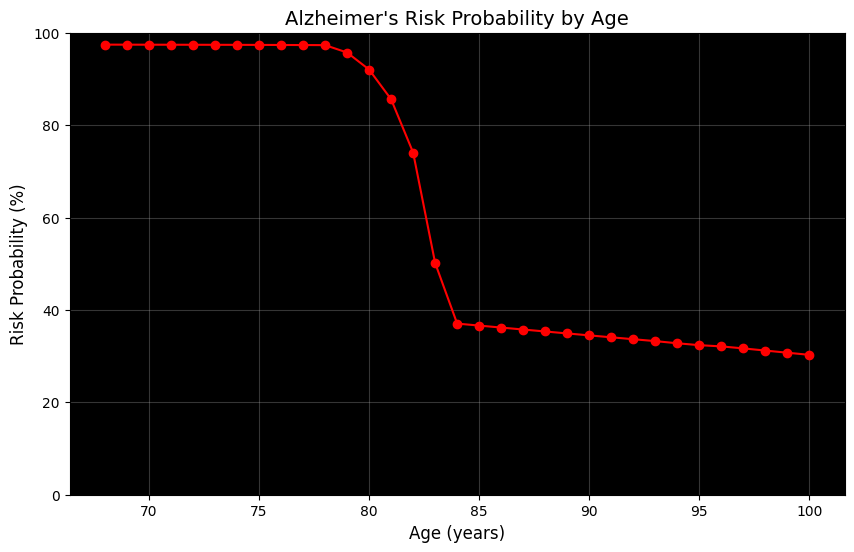

In [37]:
import matplotlib.pyplot as plt

def generate_age_risk(sample: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame for one patient, iterating their age from 10 years prior to 100,
    updating 'Age' and incrementing 'FunctionalAssessment' by +1 when age exceeds original,
    while keeping other features constant. Caps FunctionalAssessment at 10.
    """
    original_age = sample["Age"].iloc[0]
    original_functional = sample["FunctionalAssessment"].iloc[0]
    start_age = max(0, original_age - 10)
    ages = np.arange(start_age, 101, 1)
    result_rows = []
    max_score = 10  

    for age in ages:
        new_row = sample.copy()
        new_row["Age"] = age
        if age > original_age:
            potential_score = original_functional + (age - original_age)
            new_row["FunctionalAssessment"] = min(potential_score, max_score)
        result_rows.append(new_row)

    return pd.concat(result_rows, ignore_index=True)

def plot_risk_over_age(model, age_variants_df):
    """
    Plots predicted risk probability vs. age for a given patient using the PyTorch model.
    
    Args:
        model: Trained PyTorch neural network
        age_variants_df: DataFrame with patient features, varying 'Age'
    """
    X_pred = age_variants_df.values
    X_pred_scaled = scaler.transform(X_pred)  
    
    X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        probs = model(X_pred_tensor).numpy()
    
    risk_percent = probs * 100  
    
    ages = age_variants_df["Age"].values
        
    plt.figure(figsize=(10, 6))
    plt.plot(ages, risk_percent, marker='o', linestyle='-', color='red')
    plt.gca().set_facecolor('black')
    plt.title("Alzheimer's Risk Probability by Age", fontsize=14)
    plt.xlabel("Age (years)", fontsize=12)
    plt.ylabel("Risk Probability (%)", fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.show()
        


sample_df = X.iloc[[13]]  
patient_age_risk = generate_age_risk(sample_df)
plot_risk_over_age(model, patient_age_risk)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


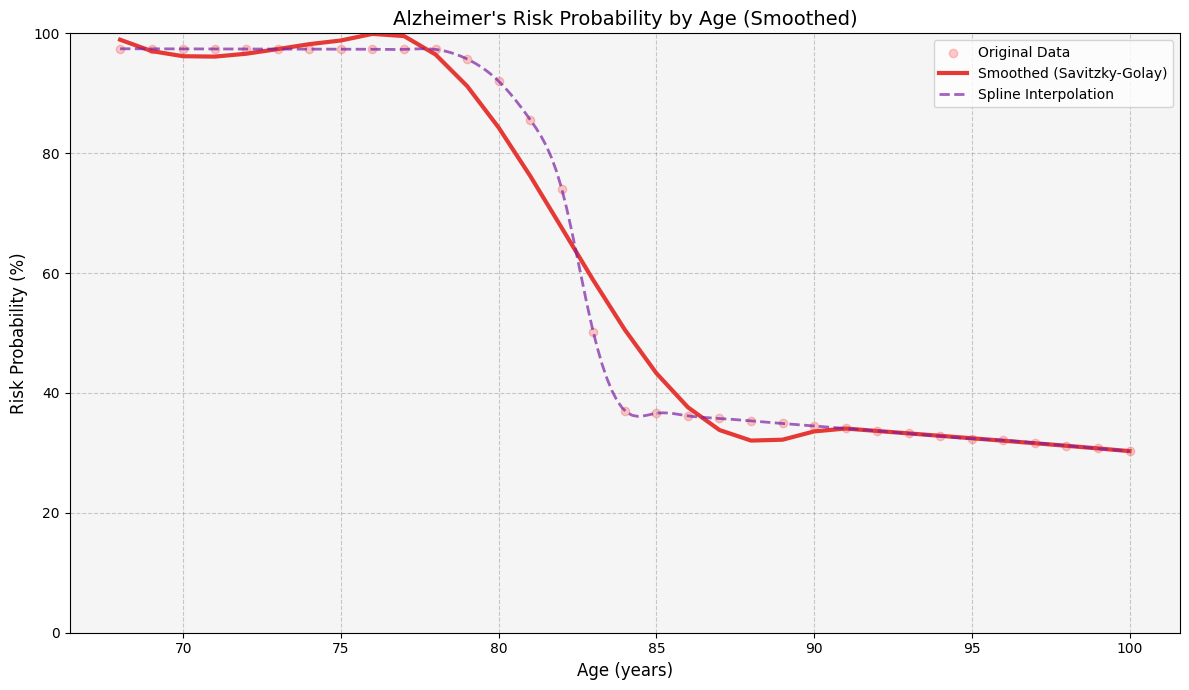

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
import pandas as pd

def plot_risk_over_age2(model, age_variants_df, scaler):
    """
    Enhanced version with multiple smoothing options and better visualization.
    """

    X_pred = age_variants_df.values
    X_pred_scaled = scaler.transform(X_pred)
    
    X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        probs = model(X_pred_tensor).numpy()
    
    risk_percent = probs * 100
    ages = age_variants_df["Age"].values
    
    plt.figure(figsize=(12, 7))
    
    plt.scatter(ages, risk_percent, color='red', alpha=0.2, label='Original Data')
    
    window_size = min(15, len(ages)-1)  
    if window_size % 2 == 0: window_size -= 1  
    smoothed_sg = savgol_filter(risk_percent.flatten(), window_size, 3)
    plt.plot(ages, smoothed_sg, color='#E53935', linewidth=3, label='Smoothed (Savitzky-Golay)')
    

    cs = CubicSpline(ages, risk_percent.flatten())
    ages_smooth = np.linspace(ages.min(), ages.max(), 200)
    smoothed_cs = cs(ages_smooth)
    plt.plot(ages_smooth, smoothed_cs, '--', color='#7B1FA2', linewidth=2, alpha=0.7, label='Spline Interpolation')
    
    plt.title("Alzheimer's Risk Probability by Age (Smoothed)", fontsize=14)
    plt.xlabel("Age (years)", fontsize=12)
    plt.ylabel("Risk Probability (%)", fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.4, color = 'grey')
    plt.gca().set_facecolor('#f5f5f5')
    plt.legend()
    plt.tight_layout()
    plt.show()

sample_df = X.iloc[[13]] 
patient_age_risk = generate_age_risk(sample_df)
plot_risk_over_age2(model, patient_age_risk, scaler) 

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import pandas as pd
import torch

def create_ultra_smooth_animation(model, age_variants_df, scaler, sample_df, 
                                 output_gif="risk_animation.gif",
                                 animation_speed=0.2, exponential_factor=3.0):
    
    age_variants_df = pd.DataFrame(age_variants_df, columns=X.columns)
    age_variants_df = age_variants_df[age_variants_df["Age"] <= 100]
    
    X_pred_scaled = scaler.transform(age_variants_df)
    X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        risk_percent = model(X_pred_tensor).numpy().flatten() * 100
    risk_percent = np.clip(risk_percent, 0, 100)
    
    ages = age_variants_df["Age"].values

    X_orig_scaled = scaler.transform(sample_df)
    X_orig_tensor = torch.tensor(X_orig_scaled, dtype=torch.float32)
    with torch.no_grad():
        orig_risk = model(X_orig_tensor).item() * 100
    orig_risk = np.clip(orig_risk, 0, 100)
    original_age = sample_df["Age"].iloc[0]

    window_size = min(15, len(ages) - 1)
    if window_size % 2 == 0:
        window_size -= 1
    smoothed_risk = savgol_filter(risk_percent, window_size, 3) if window_size > 1 else risk_percent

    ages_hires = np.linspace(ages.min(), 100, 200)
    smoothed_risk_hires = interp1d(ages, smoothed_risk, kind='cubic', fill_value="extrapolate")(ages_hires)

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_xlim(ages.min(), 100)
    ax.set_ylim(0, 100)
    ax.set_title("NeuroCurve's Alzheimers Risk", fontsize=14)
    ax.set_xlabel("Functional Assessment Improvement Over Time", fontsize=12)
    ax.set_ylabel("Risk Probability (%)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_facecolor('black')

    line, = ax.plot([], [], color='#90EE90', linewidth=7)
    moving_point = ax.scatter([], [], color='#90EE90', s=100, zorder=10)
    original_point = ax.scatter(original_age, orig_risk, color='#FF5733', s=150, 
                               zorder=15, label=f'Current Risk (Age {original_age:.0f}: {orig_risk:.1f}%)')
    ax.legend(loc='lower left')
    
    info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                       fontsize=12, ha='left', va='top',
                       bbox=dict(facecolor='white', alpha=0.7))

    total_frames = int(len(ages_hires) * animation_speed)
    t = np.linspace(0, 1, total_frames)
    exp_t = (np.exp(exponential_factor * t) - 1) / (np.exp(exponential_factor) - 1)
    frame_indices = (exp_t * (len(ages_hires) - 1)).astype(int)

    # Calculate the number of delay frames needed (3 seconds at 15 fps)
    delay_frames = int(3 * 15)  # 3 seconds * 15 fps
    
    def update(frame):
        if frame < total_frames:
            idx = frame_indices[frame]
            line.set_data(ages_hires[:idx+1], smoothed_risk_hires[:idx+1])
            moving_point.set_offsets([[ages_hires[idx], smoothed_risk_hires[idx]]])
            info_text.set_text(f'Projected Age: {ages_hires[idx]:.1f}\nRisk: {smoothed_risk_hires[idx]:.1f}%')
        else:
            # During delay frames, keep displaying the final state
            pass
        return line, moving_point, original_point, info_text

    # Create animation with the additional delay frames
    ani = FuncAnimation(fig, update, frames=total_frames + delay_frames,
                       interval=int(150/animation_speed), blit=True, repeat=True)
    
    # Save with loop=0 for infinite looping (default)
    ani.save(output_gif, writer='pillow', fps=15, dpi=100)
    plt.close()
    
    return HTML(f'<img src="{output_gif}">')


sample_df = X.iloc[[13]] 
patient_age_risk = generate_age_risk(sample_df)
create_ultra_smooth_animation(model, patient_age_risk, scaler, sample_df)

In [51]:
def generate_age_risk(
    sample: pd.DataFrame,
    metrics_to_improve: list = ["FunctionalAssessment"],
    improvement_rate: float = 1.0,
    max_values: dict = None,
    min_values: dict = None,
    custom_directions: dict = None
) -> pd.DataFrame:
    
    default_bounds = {
        "FunctionalAssessment": {"max": 10, "min": 0, "default_dir": "increase"},
        "PhysicalActivity": {"max": 10, "min": 0, "default_dir": "increase"},
        "DietQuality": {"max": 10, "min": 0, "default_dir": "increase"},
        "SleepQuality": {"max": 10, "min": 0, "default_dir": "increase"},
        "BMI": {"max": 40, "min": 18.5, "default_dir": "decrease"},
        "AlcoholConsumption": {"max": 20, "min": 0, "default_dir": "decrease"}
    }

    max_values = max_values or {}
    min_values = min_values or {}
    custom_directions = custom_directions or {}

    original_age = sample["Age"].iloc[0]
    start_age = max(0, original_age - 10)
    ages = np.arange(start_age, 101, 1)
    result_rows = []

    for age in ages:
        new_row = sample.copy()
        new_row["Age"] = age
        
        if age > original_age:
            for metric in metrics_to_improve:
                if metric in new_row.columns:
                    original_value = sample[metric].iloc[0]
                    years_passed = age - original_age
                    
                    direction = custom_directions.get(metric)
                    if direction is None and metric in default_bounds:
                        direction = default_bounds[metric]["default_dir"]
                    
                    bounds = default_bounds.get(metric, {})
                    max_val = max_values.get(metric, bounds.get("max"))
                    min_val = min_values.get(metric, bounds.get("min"))
                    
                    if direction == "increase":
                        new_value = original_value + years_passed * improvement_rate
                        if max_val is not None:
                            new_value = min(new_value, max_val)
                    elif direction == "decrease":
                        new_value = original_value - years_passed * improvement_rate
                        if min_val is not None:
                            new_value = max(new_value, min_val)
                    else:  # Neutral - no change
                        new_value = original_value
                    
                    new_row[metric] = new_value
        
        result_rows.append(new_row)

    return pd.concat(result_rows, ignore_index=True)


# patient_age_risk = generate_age_risk(sample_df, ['AlcoholConsumption'])

# patient_age_risk = generate_age_risk(sample_df, ['BMI', 'DietQuality', 'SleepQuality'])

# patient_age_risk = generate_age_risk(sample_df, ['CustomMetric'], custom_directions={'CustomMetric': 'increase'})

# patient_age_risk = generate_age_risk(sample_df,  ['BMI', 'PhysicalActivity', 'DietQuality', 'SleepQuality'],
#                                    improvement_rate=0.5,
#                                    max_values={'PhysicalActivity': 8},
#                                    min_values={'BMI': 22})

def create_ultra_smooth_animation(model, age_variants_df, scaler, sample_df, 
                                 output_gif="risk_animation_variable.gif",
                                 animation_speed=0.2, exponential_factor=3.0,
                                 metrics_to_improve: list = ["FunctionalAssessment"]):
    
    age_variants_df = pd.DataFrame(age_variants_df, columns=X.columns)
    age_variants_df = age_variants_df[age_variants_df["Age"] <= 100]
    
    X_pred_scaled = scaler.transform(age_variants_df)
    X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        risk_percent = model(X_pred_tensor).numpy().flatten() * 100
    risk_percent = np.clip(risk_percent, 0, 100)
    
    ages = age_variants_df["Age"].values

    X_orig_scaled = scaler.transform(sample_df)
    X_orig_tensor = torch.tensor(X_orig_scaled, dtype=torch.float32)
    with torch.no_grad():
        orig_risk = model(X_orig_tensor).item() * 100
    orig_risk = np.clip(orig_risk, 0, 100)
    original_age = sample_df["Age"].iloc[0]

    window_size = min(15, len(ages) - 1)
    if window_size % 2 == 0:
        window_size -= 1
    smoothed_risk = savgol_filter(risk_percent, window_size, 3) if window_size > 1 else risk_percent

    ages_hires = np.linspace(ages.min(), 100, 200)
    smoothed_risk_hires = interp1d(ages, smoothed_risk, kind='cubic', fill_value="extrapolate")(ages_hires)

    title_string = ", ".join(metrics_to_improve)

    risk_improvement = (orig_risk - smoothed_risk_hires) / orig_risk * 100
    risk_improvement = np.clip(risk_improvement, -100, 100)  
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_xlim(ages.min(), 100)
    ax.set_ylim(0, 100)
    ax.set_title("NeuroCurve's Alzheimers Risk", fontsize=14, color = 'white')
    ax.set_xlabel(title_string + " improvements over time (Age)", fontsize=12, color = 'white')
    ax.set_ylabel("Risk Probability (%)", fontsize=12, color = 'white')
    ax.grid(True, linestyle='--', alpha=0.8, color='grey')
    ax.set_facecolor('black')
    ax.figure.patch.set_facecolor(color='black')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    for spine in ax.spines.values():
        spine.set_linewidth(2.5) 
        spine.set_color('white')

    line, = ax.plot([], [], color='#90EE90', linewidth=7)
    moving_point = ax.scatter([], [], color='#90EE90', s=100, zorder=10)
    original_point = ax.scatter(original_age, orig_risk, color='blue', s=150, 
                               zorder=15, label=f'Current Risk (Age {original_age:.0f}: {orig_risk:.1f}%)')
    ax.legend(loc='lower left')
    
    info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                       fontsize=12, ha='left', va='top',
                       bbox=dict(facecolor='grey', alpha=0.9))
    
    improvement_text = ax.text(0.02, 0.5, '', transform=ax.transAxes,
                             fontsize=14, ha='left', va='center', weight='bold',
                             bbox=dict(facecolor='grey', alpha=0.9, linewidth=2))

    total_frames = int(len(ages_hires) * animation_speed)
    t = np.linspace(0, 1, total_frames)
    exp_t = (np.exp(exponential_factor * t) - 1) / (np.exp(exponential_factor) - 1)
    frame_indices = (exp_t * (len(ages_hires) - 1)).astype(int)

    delay_frames = int(3 * 15)  
    
    def update(frame):
        if frame < total_frames:
            idx = frame_indices[frame]
            current_risk = smoothed_risk_hires[idx]
            current_improvement = risk_improvement[idx]
            
            line.set_data(ages_hires[:idx+1], smoothed_risk_hires[:idx+1])
            moving_point.set_offsets([[ages_hires[idx], current_risk]])
            
            info_text.set_text(f'Projected Age: {ages_hires[idx]:.1f}\nRisk: {current_risk:.1f}%')
            
            improvement_color = '#2ECC71' if current_improvement > 0 else '#E74C3C'
            improvement_text.set_text(f'Risk Improvement:\n{current_improvement:.1f}%')
            improvement_text.set_color(improvement_color)
            
                
        else:
            pass
            
        return line, moving_point, original_point, info_text, improvement_text

    ani = FuncAnimation(fig, update, frames=total_frames + delay_frames,
                       interval=int(150/animation_speed), blit=True, repeat=True)
    
    ani.save(output_gif, writer='pillow', fps=15, dpi=100)
    plt.close()
    
    return HTML(f'<img src="{output_gif}">')

sample_df = X.iloc[[13]] 
# FunctionalAssessment, SleepQuality, PhysicalActivity, BMI, AlcoholConsumption, Dietquality
# ^ all available inputs for the patient_age_risk list 
patient_age_risk = generate_age_risk(sample_df, ['FunctionalAssessment'])
create_ultra_smooth_animation(model, patient_age_risk, scaler, sample_df, metrics_to_improve=['FunctionalAssessment'])